# Setup

The below [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) extension ensures that if any locally imported python files change, the modules defined there are reloaded

In [1]:
%load_ext autoreload
%autoreload 2

The below imports [`here`](https://pypi.org/project/pyprojroot/), which allows one to refer to the root directory of the project in a consistent manner across execution environments. It then adds `here()` (the root directory) to the system path to ensure that we can load python modules defined in the project.

In [2]:
from hereutil import here, add_to_sys_path
add_to_sys_path(here())

Having ensured that the root path of the project is in the system path, we can load common basis functions from [src/common_basis.py](/src/common_basis.py). The template assumes that functions useful for most work be defined in `common_basis.py`, whereas code useful for individual analyses is defined where needed.

Naturally, if more refined organisation of common code is needed, one is also free to define whichever other modules one wants.

The central object defined in `common_basis` is `con`, which is the [MariaDB](https://mariadb.com/) (MySQL) database connection (an [SQLAlchemy Connection](https://docs.sqlalchemy.org/en/14/core/connections.html)) through which both ready data is accessed, as well as new data stored for others to reuse. Below, you will see both how to use con to store data in the database, as well as how query it.

The details of the database connection are stored in [`db_params.yaml`](/db_params.yaml). The password is given separately. **DO NOT INCLUDE THE PASSWORD IN ANY CODE YOU COMMIT TO GITHUB**. If running this notebook, it will ask for the password the first time you run it, and then store it separately in your keyring. This requires a working keyring implementation on your system. Consult the [`keyring`](https://pypi.org/project/keyring/) package documentation if you have problems.  If you cannot get it to work, a second option is to create a `db_secret.yaml` file in the project root directory with `db_pass: [PASSWORD]` as the content. This file is already set to be ignored by Git so it wouldn't accidentally get included in a commit, but still, if you do this, **DON'T MAKE THE MISTAKE OF COMMITTING THE FILE TO GITHUB**.


In [3]:
from src.common_basis import *
eng, con = get_connection()

# Storing data in the database

In [5]:
from sqlalchemy import text
import pandas as pd

# create some sample data
d = pd.DataFrame(data={
    'year': [1700, 1710, 1710, 1713],
    'type': ['book', 'pamphlet', 'pamphlet', 'pamphlet'],
    'genre': ['drama', 'literature', 'science', 'drama']
})

# this copies the sample data to the database. con is the connection object that is defined in common_basis. Additionally for efficiency reasons, we want the created table to be an Aria table, not an InnoDB table.
set_session_storage_engine(con, "Aria")
d.to_sql("test_a", con, index=False, method="multi", if_exists="replace")

# Here, we also create a ColumnStore (https://mariadb.com/kb/en/mariadb-columnstore/) version of the table. ColumnStore tables are very good for large aggregate queries, but support for them is still a bit quirky, so some queries may just not work. They're also slower for queries that mainly seek and return individual full rows of data. Further, it is better not to mix ColumnStore and other tables in queries.
set_session_storage_engine(con, "ColumnStore")
d.to_sql("test_c", con, index=False, method="multi", if_exists="replace")

4

# Data analysis

Transferring complete tables from the database to local pandas dataframes works as follows (don't do this with very large tables):

In [27]:
d = pd.read_sql_table("test_a", con)
d

,year,type,genre
0,1700,book,drama
1,1710,pamphlet,literature
2,1710,pamphlet,science
3,1713,pamphlet,drama


If you have larger tables, you are much better off running e.g. aggregation queries using SQL, and then just reading the results:

In [28]:
d = pd.read_sql(text("""
SELECT year, COUNT(*) AS books
FROM test_c
GROUP BY year
"""), con)
d

,year,books
0,1710,2
1,1713,1
2,1700,1


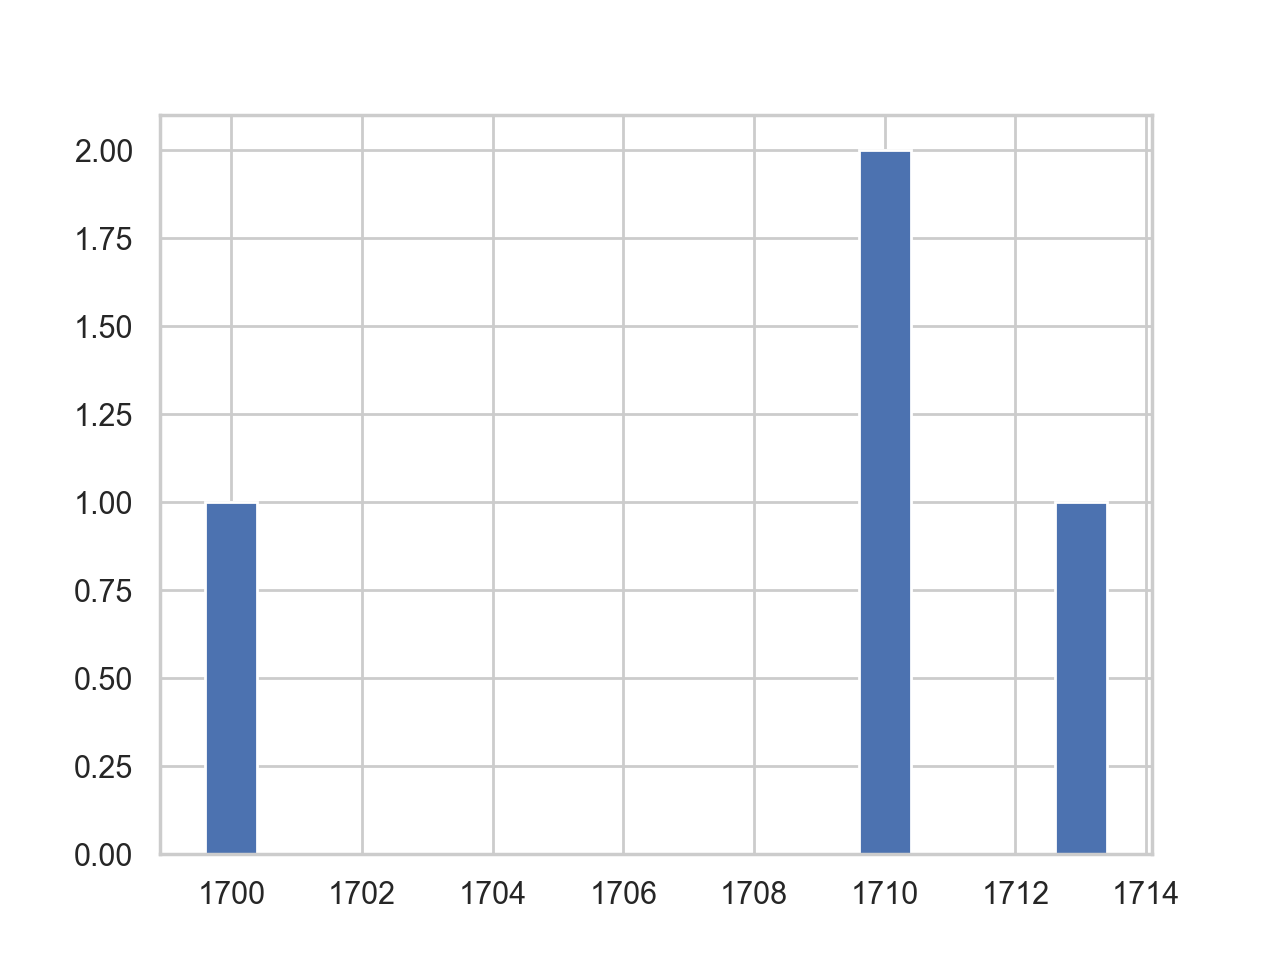

In [48]:
import matplotlib.pyplot as plt
d = pd.read_sql(text("""
SELECT year, COUNT(*) AS books
FROM test_c
GROUP BY year
"""), con)
plt.bar(d.year,d.books)
plt.show()